In [1]:
import pandas as pd
import numpy as np
import bz2
import os

import re
import gc

import tensorflow as tf
from tensorflow.python.keras import models, layers, optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [2]:
def assign_labels_and_comments(file):
    labels = []
    comments = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        comments.append(x[10:].strip())
    return np.array(labels), comments

In [3]:
train_labels, train_comments = assign_labels_and_comments('C:/Users/2111s/Music/train.ft.txt.bz2')
test_labels, test_comments = assign_labels_and_comments('C:/Users/2111s/Music/test.ft.txt.bz2')

In [4]:
#This function cleans up text so that only English characters are preserved
not_alphanumeric = re.compile(r'[\W]')
not_ascii = re.compile(r'[^a-z0-1\s]')

In [5]:
def processed_comments(texts):
    processed_comments = []
    for text in texts:
        lower = text.lower()
        no_punctuation = not_alphanumeric.sub(r' ', lower)
        no_non_ascii = not_ascii.sub(r'', no_punctuation)
        processed_comments.append(no_non_ascii)
    return processed_comments

In [6]:
train_comments = processed_comments(train_comments)
test_comments = processed_comments(test_comments)

In [7]:
train_comments, val_comments, train_labels, val_labels = train_test_split(train_comments, train_labels, random_state=42, test_size=0.2)

In [8]:
print('Train Length ', len(train_comments))
print('Train Label Length ', len(train_labels))
print('Test Length ', len(test_comments))
print('Test Labels Length ', len(test_labels))

Train Length  2880000
Train Label Length  2880000
Test Length  400000
Test Labels Length  400000


In [9]:
"""Printing first comment from the dataset
NOTE: The assign_labels_and_comments function reads a bz2 compressed text file (train.ft.txt.bz2 and test.ft.txt.bz2)
containing labeled comments.
It extracts labels (0 or 1) and comments from each line of the file.
Labels are derived from the 10th character of each line, and comments are the remaining part of the line.
The function returns numpy arrays of labels and comments."""

train_comments[0],train_labels[0]

('wow       not since the soundtrack to titanic has james horner done such a great job  the music on this cd is riveting and works extremely well with the movie  josh groban s remember me is a great highlight   but the best part of this cd has to be tanya tzarovska whose middle eastern sounding wails are so rich and full of life    they just make the score come alive   plus  she and josh sound so great together   one thing though  don t buy this cd before seeing the movie    a couple of the song titles give the plot away  other than that  this is one great score   and josh may be rivaling celine dion for best singer of james horner songs ',
 1)

In [10]:
# To get the count of comments from Label 0 and Label 1 from Training dataset
pd.DataFrame(train_labels).value_counts()

0    1440241
1    1439759
dtype: int64

Text(0, 0.5, 'Count')

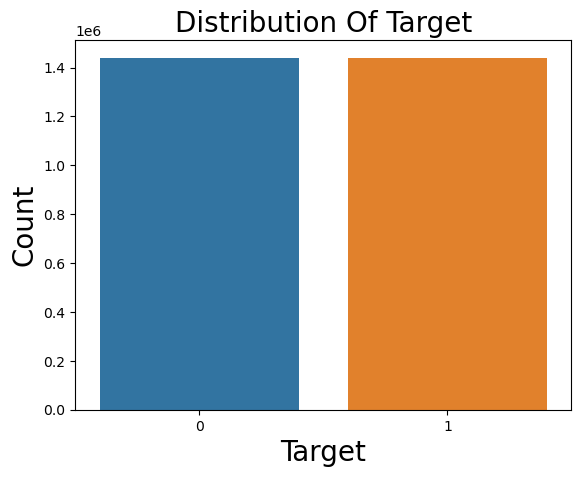

In [11]:
#Plotting Bar graph on the dataset: Train
sns.countplot(x=pd.DataFrame(train_labels)[0])
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)

In [12]:
# To get the count of comments from Label 0 and Label 1 from Testing dataset
pd.DataFrame(test_labels).value_counts()

0    200000
1    200000
dtype: int64

Text(0, 0.5, 'Count')

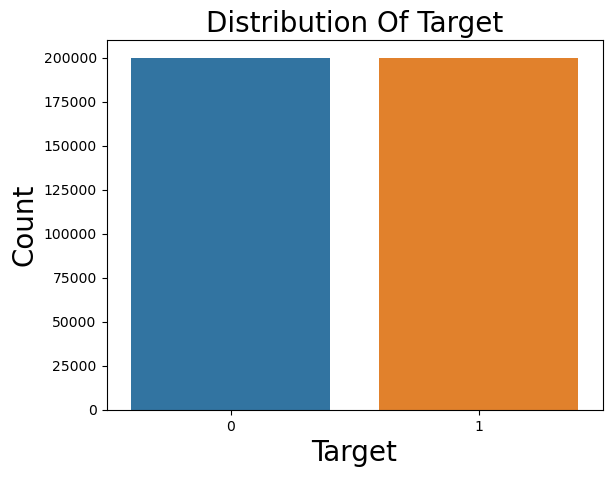

In [13]:
#Plotting Bar graph on the dataset: Test
sns.countplot(x=pd.DataFrame(test_labels)[0])
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)

In [14]:
def clean_text(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    text=re.sub(r'\s+',' ',text)
    text=text.lower()
    return text 
train=pd.DataFrame(train_comments)[0].apply(clean_text)
test=pd.DataFrame(test_comments)[0].apply(clean_text)
train.head(20)

0     wow not since the soundtrack to titanic has ja...
1     the sequel to mara and dann while not as excel...
2     the full story i love this adaptation of pride...
3     very nice this cd has a lot of very nice songs...
4     not as advertised when i took the cover out of...
5     aburrido pienso que no es lo mismo leer el lib...
6     disturbing i thought this would be a great boo...
7     impossible to use the elura or mc effectively ...
8     silly book for silly people i grew up loving s...
9     hack journalism i have never watched fox news ...
10    streetwalking fluff if you re interested in fi...
11    good product tricky setup very nice product ge...
12    if you like to dance it s fun but i loved the ...
13    a must have true the lyrics are sometimes depr...
14    don t waste your money for this type of protec...
15    love it we had a carrier from llbean and had s...
16    love these my daughter loves these niples she ...
17    serious paint issue i would advise against

In [15]:
data = {
    'text': train,
    'textLabels':train_labels
}
# Create DataFrame
df_train = pd.DataFrame(data)
df_train.head()

,text,textLabels
0,wow not since the soundtrack to titanic has ja...,1
1,the sequel to mara and dann while not as excel...,1
2,the full story i love this adaptation of pride...,1
3,very nice this cd has a lot of very nice songs...,1
4,not as advertised when i took the cover out of...,0


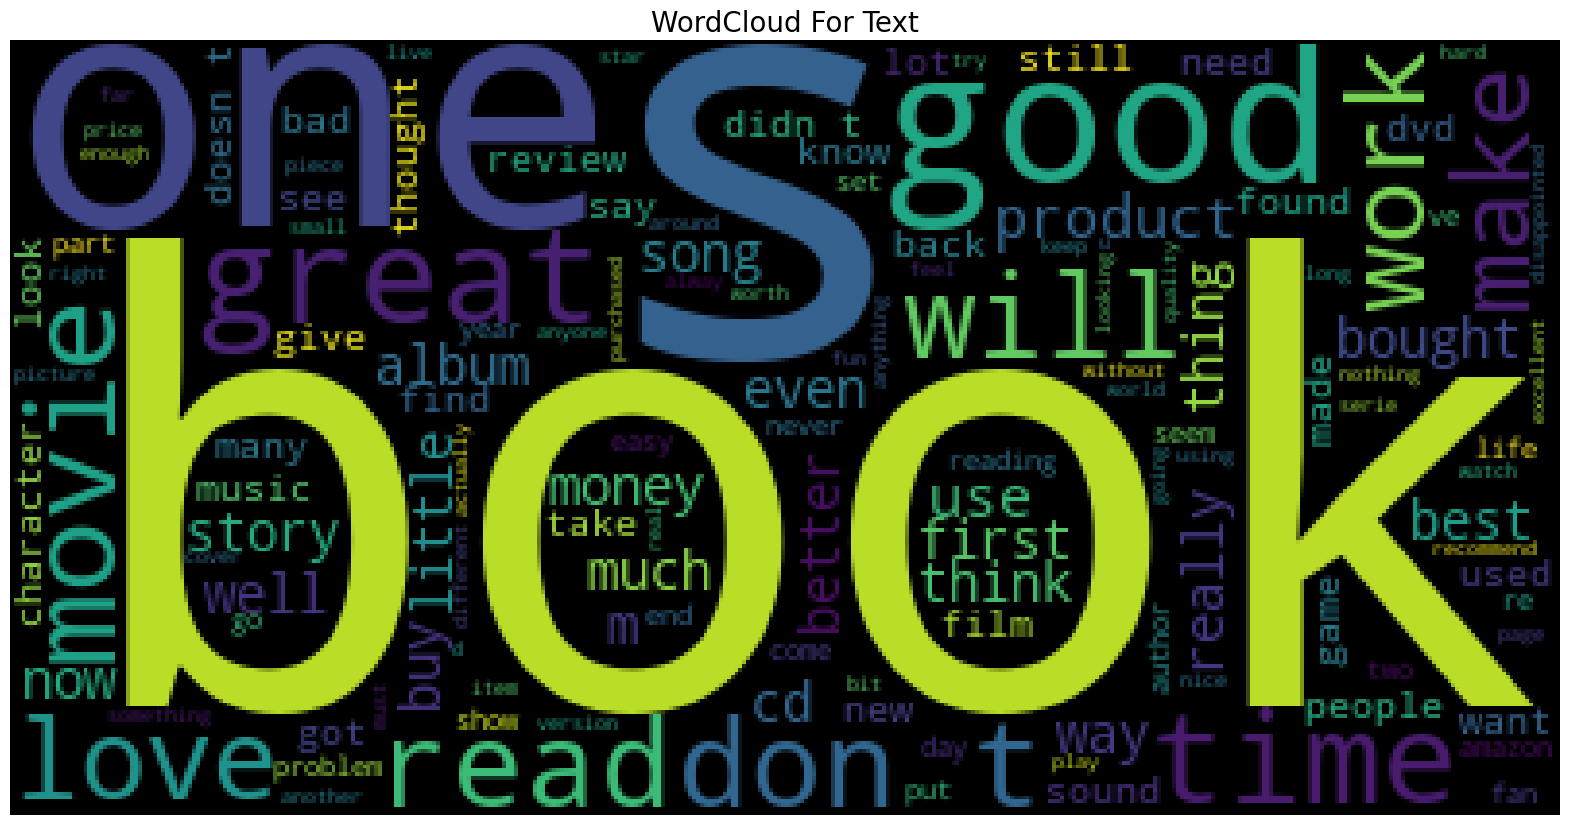

In [16]:
"""This code creates a word cloud that shows the most frequent words in a set of texts,
and this helps in understanding the most important topics and ideas discussed in these texts. """

from wordcloud import WordCloud
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(" ".join(train.iloc[:20000])))
plt.axis("off")
plt.title("WordCloud For Text",fontsize=20)
plt.show()

Model Creation: Using LSTM layers

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
from tensorflow.keras.optimizers import SGD, Adam
import bz2
import csv
from sklearn.metrics import roc_auc_score

max_words = 1000
max_sequence_length = 100

Tokenizing and Padding the Dataset
A)Convert text into digital sequences using the tokenizer tool.
B)Standardizing the lengths of sequences so that they are compatible with the machine learning model that will be trained on it.
C)This allows the model to deal with texts effectively during the training and testing process.

In [18]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_comments)

X_train = tokenizer.texts_to_sequences(train_comments)
X_test = tokenizer.texts_to_sequences(test_comments)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [19]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(train_labels)
print(y_train.shape)
y_test = np.array(test_labels)
print(y_test.shape)

(2880000, 100)
(400000, 100)
(2880000,)
(400000,)


In [20]:
print(type(X_train[0]))
print(type(X_test[0]))
print(type(y_train[0]))
print(type(y_test[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.int32'>


Model Creation and Training

In [21]:
def create_model(optimizer, activation_function, lstm_layers):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    for _ in range(lstm_layers):
        model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(1, activation=activation_function))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define different configurations
configurations = [
    {"optimizer": SGD(learning_rate=0.01), "activation_function": 'sigmoid', "lstm_layers": 1},
    {"optimizer": Adam(learning_rate=0.001), "activation_function": 'relu', "lstm_layers": 2},
]

results = []

for config in configurations:
    model = create_model(config["optimizer"], config["activation_function"], config["lstm_layers"])
    model.fit(X_train, y_train, epochs=6, batch_size=2048, verbose=1)
    loss, accuracy = model.evaluate(X_test, y_test)
    results.append({"config": config, "loss": loss, "accuracy": accuracy})

Epoch 1/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3023s 2s/step - accuracy: 0.5323 - loss: 0.6929
Epoch 2/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3054s 2s/step - accuracy: 0.5679 - loss: 0.6925
Epoch 3/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3107s 2s/step - accuracy: 0.5898 - loss: 0.6920
Epoch 4/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3298s 2s/step - accuracy: 0.6070 - loss: 0.6908
Epoch 5/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3218s 2s/step - accuracy: 0.6023 - loss: 0.6838
Epoch 6/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3190s 2s/step - accuracy: 0.6413 - loss: 0.6308
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 334s 27ms/step - accuracy: 0.7262 - loss: 0.5558
Epoch 1/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5117s 4s/step - accuracy: 0.7705 - loss: 0.5260
Epoch 2/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5225s 4s/step - accuracy: 0.7892 - loss: 0.4768
Epoch 3/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5204s 4s/step - accuracy: 0.8772 - loss: 0.2939
Epoch 4/6
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5229s 4s/step - accuracy: 0.8998 - loss: 0.2691
Epoch 5/6
1407/1407 ━━━━━━━━

Model Evaluation

In [22]:
for result in results:
    config = result["config"]
    loss = result["loss"]
    accuracy = result["accuracy"]
    print(f"Configuration: Optimizer={config['optimizer']}, Activation={config['activation_function']}, LSTM Layers={config['lstm_layers']}")
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}\n")

Configuration: Optimizer=<keras.src.optimizers.sgd.SGD object at 0x000002298D86E5D0>, Activation=sigmoid, LSTM Layers=1
Test Loss: 0.5524522066116333, Test Accuracy: 0.7292575240135193

Configuration: Optimizer=<keras.src.optimizers.adam.Adam object at 0x000002298D62AA90>, Activation=relu, LSTM Layers=2
Test Loss: 0.2787620425224304, Test Accuracy: 0.902305006980896



In [23]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 532s 43ms/step


Confusion Matrix:


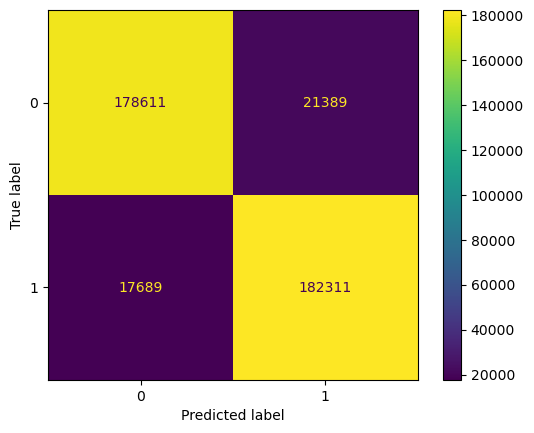

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90    200000
           1       0.89      0.91      0.90    200000

    accuracy                           0.90    400000
   macro avg       0.90      0.90      0.90    400000
weighted avg       0.90      0.90      0.90    400000



In [24]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
ConfusionMatrixDisplay(cm).plot()
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)